In [1]:
import sys
print(sys.executable)

C:\Users\zouru\anaconda3\envs\tf-gpu\python.exe


In [2]:
import os
import glob
import numpy as np
from skimage import io, color, exposure, transform
from PIL import Image
from os import listdir

# Train set

In [29]:
pic_dir= r'new_zoom\rz_pos5_white2'

def mapper(lst,f):
    return list(map(lambda x: f(x),lst))


# set plugin = matplotlib'
def preprocessimg(path):
    img = io.imread(path,plugin='matplotlib')  
    img = img/255
    img = transform.resize(img,(64,114))
    
    # swap axes to make image from (224, 224, 3) to (3, 224, 224)
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    
    return img



all_img_paths = glob.glob(os.path.join(pic_dir, '*'))
np.random.shuffle(all_img_paths)

imgs=[]
labels = []   #, not relevant here as no labels

# file_names = []
# for img_path in all_img_paths:
#         img = preprocessimg(img_path)
#         imgs.append(img)
        
#         # label assignment
#         file_name= img_path.split('\\')[-1].replace('.jpg','')
        
#         file_names.append(file_name)
        
#         if int(file_name[1])>=5:
#             labels.append(0)
#         else:
#             labels.append(1)
 
# x = np.array(imgs, dtype='float32')
# y = np.eye(2,dtype='uint8')[mapper(labels,int)]

# print('rz_pos5')




white_dir = 'new_zoom\\white'
all_white_imgs = glob.glob(os.path.join(white_dir, '*'))

# .extend()  &  .shuffle()  does not return anything does not require assignment
all_white_imgs.extend(all_img_paths)
np.random.shuffle(all_white_imgs)

new_imgs=[]
new_labels = []   #, not relevant here as no labels

file_names = []
for img_path in all_white_imgs:
        img = preprocessimg(img_path)
        imgs.append(img)
        
        # label assignment
        file_name= img_path.split('\\')[-1].replace('.jpg','')
        # file_names.append(file_name)
        
        if int(file_name[1])>=5:
            labels.append(0)
        else:
            labels.append(1)
 
x_comb = np.array(imgs, dtype='float32')

#float_y = mapper(labels,int)
y_comb = np.eye(2,dtype='uint8')[mapper(labels,int)]

print('rz white completed')

rz white completed


In [31]:
x_comb.shape,y_comb.shape

((201, 3, 64, 114), (201, 2))

# Test set

In [15]:
test = glob.glob(os.path.join('new_zoom\\test_data', '*' ) )


def mapper(lst,f):
    return list(map(lambda x: f(x),lst))


# set plugin = matplotlib'
def preprocessimg(path):
    img = io.imread(path,plugin='matplotlib')  
    img = img/255
    img = transform.resize(img,(64,114))
    
    # swap axes to make image from (224, 224, 3) to (3, 224, 224)
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    
    return img


def parser(img_dir_list):
    np.random.shuffle(img_dir_list)

    new_imgs=[]
    new_labels = []   #, not relevant here as no labels

    file_names = []
    for img_path in img_dir_list:
            img = preprocessimg(img_path)
            new_imgs.append(img)

            # label assignment
            
            file_name = img_path.split('\\')[-1].replace('.jpg','')
            # file_names.append(file_name)

            #second digit
            if int(file_name[1]) not in [1,2,3,4]:
                 new_labels.append(0)
            else:
                new_labels.append(1)

    x_comb = np.array(new_imgs)

    y_comb = np.eye(2,dtype='uint8')[mapper(new_labels,int)]
    
    return x_comb,y_comb

In [16]:
xtest,ytest = parser(test)

In [21]:
xtest.shape,ytest.shape

((326, 3, 64, 114), (326, 2))

In [18]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
# import BatchNormalization
from keras.layers.normalization import BatchNormalization


from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

In [8]:
def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

['/device:GPU:0']

# Model training & Eval

In [33]:
from sklearn.model_selection import train_test_split

X2_train, X2_val, Y2_train, Y2_val = train_test_split(x_comb, y_comb, test_size=0.2, random_state=42)

datagen2 = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.,)

datagen2.fit(X2_train)

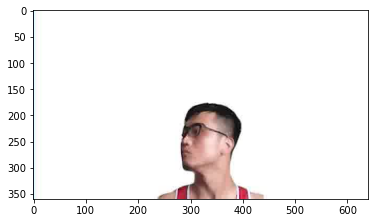

In [40]:
import matplotlib.pyplot as plt

plt.imshow(io.imread(all_white_imgs[0]))

In [73]:
def deep_model2():
    model = Sequential()

    # 1st convblock
    model.add(Conv2D(32, (5, 5), padding='same',
                     input_shape=(3, 64,114),
                     activation='relu'))
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    
    # 2nd conv block
    model.add(Conv2D(64, (5, 5), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
   

    # 3rd conv block
    model.add(Conv2D(128, (5, 5), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # 4rd conv block 
    model.add(Flatten())
    model.add(Dense(230, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    
    return model


with tf.device('/GPU:0'):
    model4 = deep_model2()
    # let's train the model using SGD + momentum (how original)

    lr = 0.01
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)


    # compile model
    model4.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[tf.keras.metrics.AUC()])


    model4_hist = model4.fit_generator( datagen2.flow(X2_train, Y2_train, batch_size=32),
                                    steps_per_epoch=X2_train.shape[0],
                                    epochs=10,
                                    validation_data=(X2_val, Y2_val),
                                    callbacks=[LearningRateScheduler(lr_schedule),
                                               ModelCheckpoint('model4.h5',save_best_only=True)] )

Epoch 1/10
160/160 [==============================] - 27s 171ms/step - loss: 0.7382 - auc_20: 0.6072 - val_loss: 0.6976 - val_auc_20: 0.6240
Epoch 2/10
160/160 [==============================] - 27s 169ms/step - loss: 0.6941 - auc_20: 0.5926 - val_loss: 0.6930 - val_auc_20: 0.5761
Epoch 3/10
160/160 [==============================] - 29s 182ms/step - loss: 0.6936 - auc_20: 0.5632 - val_loss: 0.6932 - val_auc_20: 0.5527
Epoch 4/10
160/160 [==============================] - 30s 186ms/step - loss: 0.6937 - auc_20: 0.5450 - val_loss: 0.6931 - val_auc_20: 0.5378
Epoch 5/10
160/160 [==============================] - 29s 183ms/step - loss: 0.6934 - auc_20: 0.5330 - val_loss: 0.6931 - val_auc_20: 0.5286
Epoch 6/10
160/160 [==============================] - 29s 183ms/step - loss: 0.6934 - auc_20: 0.5250 - val_loss: 0.6931 - val_auc_20: 0.5222
Epoch 7/10
160/160 [==============================] - 29s 183ms/step - loss: 0.6936 - auc_20: 0.5191 - val_loss: 0.6932 - val_auc_20: 0.5166
Epoch 8/10
16

In [74]:
model4.evaluate( xtest, ytest , verbose=1 )

326/326 [==============================] - 0s 1ms/step


[0.6939948468120551, 0.5081462264060974]

In [41]:
def deep_model2():
    model = Sequential()

    # 1st convblock
    model.add(Conv2D(32, (5, 5), padding='same',
                     input_shape=(3, 64,114),
                     activation='relu'))
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    
    
    # 2nd conv block
    model.add(Conv2D(64, (5, 5), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
   
    
    # 4rd conv block 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    
    return model


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))


with tf.device('/GPU:0'):
    model4 = deep_model2()
    # let's train the model using SGD + momentum (how original)

    lr = 0.01
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)


    # compile model
    model4.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[tf.keras.metrics.AUC()])


    model4_hist = model4.fit_generator( datagen2.flow(X2_train, Y2_train, batch_size=32),
                                    steps_per_epoch=X2_train.shape[0],
                                    epochs=10,
                                    validation_data=(X2_val, Y2_val),
                                    callbacks=[LearningRateScheduler(lr_schedule),
                                               ModelCheckpoint('model4.h5',save_best_only=True)] )

Epoch 1/10
160/160 [==============================] - 24s 153ms/step - loss: 0.4845 - auc_5: 0.6422 - val_loss: 1.8821 - val_auc_5: 0.8409
Epoch 2/10
160/160 [==============================] - 23s 146ms/step - loss: 5.6513e-04 - auc_5: 0.9192 - val_loss: 2.4225e-05 - val_auc_5: 0.9588
Epoch 3/10
160/160 [==============================] - 26s 162ms/step - loss: 9.4940e-05 - auc_5: 0.9722 - val_loss: 4.5154e-06 - val_auc_5: 0.9811
Epoch 4/10
160/160 [==============================] - 29s 181ms/step - loss: 6.8123e-05 - auc_5: 0.9857 - val_loss: 1.7213e-06 - val_auc_5: 0.9891
Epoch 5/10
160/160 [==============================] - 26s 165ms/step - loss: 6.5823e-05 - auc_5: 0.9912 - val_loss: 1.0874e-06 - val_auc_5: 0.9928
Epoch 6/10
160/160 [==============================] - 28s 173ms/step - loss: 3.1433e-05 - auc_5: 0.9939 - val_loss: 6.8327e-07 - val_auc_5: 0.9949
Epoch 7/10
160/160 [==============================] - 28s 174ms/step - loss: 3.0836e-05 - auc_5: 0.9956 - val_loss: 7.4142e-07

In [44]:
model4.evaluate( xtest, ytest , verbose=1 )

326/326 [==============================] - 0s 906us/step


[8.726268528429276, 0.9922192096710205]

In [45]:
model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 64, 114)       2432      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 60, 110)       25632     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 15, 27)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 15, 27)        108       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 15, 27)        51264     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 64, 11, 23)        102464    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 2, 5)         

In [ ]:
# dropped alot of Conv2dlayers
increased size of pooling to (4,4)

# dropping conv2d layer 2 auroc gg

In [68]:
def deep_model3():
    model = Sequential()

    # 1st convblock
    model.add(Conv2D(32, (5, 5), padding='same',
                     input_shape=(3, 64,114),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    
    # 2nd conv block
    model.add(Conv2D(64, (5, 5), padding='same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
   
    
    # 4rd conv block 
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    
    return model


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))


with tf.device('/GPU:0'):
    model5 = deep_model3()
    # let's train the model using SGD + momentum (how original)

    lr = 0.01
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)


    # compile model
    model5.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[tf.keras.metrics.AUC()])


    model5_hist = model5.fit_generator( datagen2.flow(X2_train, Y2_train, batch_size=32),
                                    steps_per_epoch = X2_train.shape[0],
                                    epochs = 10,
                                    validation_data = (X2_val, Y2_val),
                                    callbacks=[LearningRateScheduler(lr_schedule),
                                               ModelCheckpoint('model5.h5',save_best_only=True)] )



Epoch 1/10
160/160 [==============================] - 25s 157ms/step - loss: 0.4915 - auc_18: 0.7802 - val_loss: 0.0550 - val_auc_18: 0.9367
Epoch 2/10
160/160 [==============================] - 26s 161ms/step - loss: 0.0097 - auc_18: 0.9618 - val_loss: 0.0369 - val_auc_18: 0.9759
Epoch 3/10
160/160 [==============================] - 28s 173ms/step - loss: 0.0041 - auc_18: 0.9817 - val_loss: 0.3159 - val_auc_18: 0.9858
Epoch 4/10
160/160 [==============================] - 26s 164ms/step - loss: 0.0017 - auc_18: 0.9883 - val_loss: 1.6118 - val_auc_18: 0.9900
Epoch 5/10
160/160 [==============================] - 27s 168ms/step - loss: 0.0016 - auc_18: 0.9913 - val_loss: 0.0381 - val_auc_18: 0.9924
Epoch 6/10
160/160 [==============================] - 29s 183ms/step - loss: 2.7960e-04 - auc_18: 0.9933 - val_loss: 0.0842 - val_auc_18: 0.9939
Epoch 7/10
160/160 [==============================] - 30s 189ms/step - loss: 0.0012 - auc_18: 0.9945 - val_loss: 0.0887 - val_auc_18: 0.9950
Epoch 8/1

In [69]:
model5.evaluate( xtest, ytest , verbose=1 )

326/326 [==============================] - 0s 728us/step


[2.419453955866808, 0.9963985085487366]

In [70]:
model5.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 32, 64, 114)       2432      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 32, 16, 28)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 16, 28)        112       
_________________________________________________________________
dropout_45 (Dropout)         (None, 32, 16, 28)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 64, 16, 28)        51264     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 64, 4, 7)          0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 64, 4, 7)        